## Exercise 5.8: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. 
* The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. 
* The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. 
* Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. 
* Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. 
* The rewards are −1 for each step until the car crosses the finish line. 
* If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. 
* Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. 
* To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. 

Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

<img src="racetrack.png" width="600">

In [13]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

CELL_TYPE_WALL = 0
CELL_TYPE_TRACK = 1
CELL_TYPE_GOAL = 2
CELL_TYPE_START = 3

class RaceTrack:
    def __init__(self, track, max_vel=5, min_vel=-5):
        self.track = track
        self.wall_cells = np.argwhere(track == CELL_TYPE_WALL)
        self.goal_cells = np.argwhere(track == CELL_TYPE_GOAL)
        self.start_cells = np.argwhere(track == CELL_TYPE_START)
        self.max_vel = max_vel
        self.min_vel = min_vel
        self.colors = ['black', 'white', 'yellow', 'red']
    
    @classmethod
    def from_csv(cls, file_path):
        
        file_path = os.path.join(os.getcwd(), file_path)
        
        track = genfromtxt(file_path, delimiter=',')

        return cls(track) 
    
    def actions(self, state):
        actions = [[a_x, a_y] for a_x in range(-1,2) for a_y in range(-1,2)]
        legal_actions = []
        
        _, _, v_x, v_y = state
        
        # Discard illegal actions
        for a in actions:
            a_x, a_y = a
            # Cannot go above speed limit in any x direction
            if v_x + a_x < self.min_vel or v_x + a_x > self.max_vel:
                continue
            # Cannot go above speed limit in any y direction
            if v_y + a_y < self.min_vel or v_y + a_y > self.max_vel:
                continue
            # Cannot noop
            if v_x + a_x == 0 and v_y + a_y == 0:
                continue
            legal_actions.append(a)
        return legal_actions
    
    def apply_action(self, state, action):
        y, x, v_y, v_x = state
        a_y, a_x = action
        
        v_y_new = v_y + a_y
        v_x_new = v_x + a_x
                
        path = projected_path((y, x), (v_y_new, v_x_new))
        
        terminated = self.crossed_finish_line(path)
            
        if not terminated and self.crossed_track_boundary(path):
            start_cell_idx = np.random.choice(self.track.start_cells.shape[0], 1, replace=False)
            start_cell = self.track.start_cells[start_cell_idx[0], :]
            start_state = np.concatenate([start_cell, [0,0]])     
        
        y_new = y + v_y
        x_new = x + v_x
        
        return np.array([y_new, x_new, v_y_new, v_x_new]), -1, terminated
        
    def projected_path(self, state, speed):
        # TODO: Should we only consider end state directly?
        y, x = state
        v_y, v_x = speed
        
        y_new = y + v_y
        x_new = x + v_x
        
        path = []        
        for dy in range(min(y, y_new), max(y, y_new) + 1):
            for dx in range(min(x, x_new), max(x, x_new) + 1):
                path.append((dy,dx))
        return path
        
    def crossed_track_boundary(self, projected_path):        
        for cell in projected_path:   
            y, x = cell
            if y < 0 or y > self.track.shape[0] or x < 0 or x > self.track.shape[1] or cell in self.wall_cells:
                return True
        return False
    
    def crossed_finish_line(self, projected_path):
        for cell in projected_path:
            if cell in self.goal_cells:
                return True
        return False  
        
    def draw(self, car_cell=None, path=[]):
        fig=plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
        
        im = plt.imshow(self.track, cmap=ListedColormap(self.colors), origin='lower', interpolation='none', animated=True)
        
        def rect(pos, edgecolor='k', facecolor='none'):
            r = plt.Rectangle(pos, 1,1, facecolor=facecolor, edgecolor=edgecolor, linewidth=2)
            plt.gca().add_patch(r)
            
        for i in range(self.track.shape[0]):
            for j in range(self.track.shape[1]):
                rect((j-0.5,i-0.5))
                
        if path:
            for cell in path:
                rect((cell[1]-0.5, cell[0]-0.5), edgecolor='g')
        
        if car_cell:
            rect((car_cell[1]-0.5, car_cell[0]-0.5), edgecolor='g', facecolor='g')
            
        plt.gca().invert_yaxis()
        return im
        

In [14]:
rt = RaceTrack.from_csv("../racetracks/map1.csv")

In [15]:
path = rt.projected_path((6,8),(-2,2))
path

[(4, 8), (4, 9), (4, 10), (5, 8), (5, 9), (5, 10), (6, 8), (6, 9), (6, 10)]

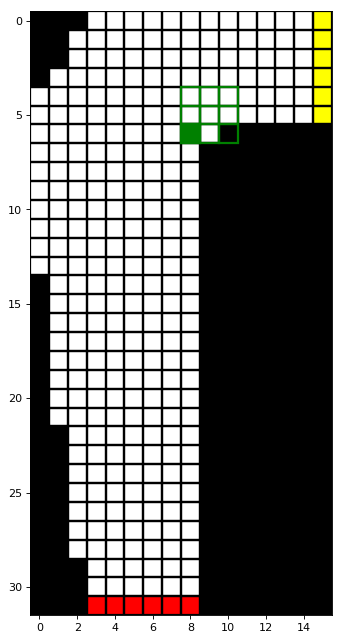

In [16]:
rt.draw((6,8),path)

In [316]:
import random
class OffPolicyMonteCarloAgent:
    def __init__(self, track, gamma = 1, n_episodes=100000):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
                
        # Initialize Q values and C values
        state_track_y_range = track.track.shape[0]
        state_track_x_range = track.track.shape[1]
        state_y_vel_range = track.max_vel - track.min_vel + 1
        state_x_vel_range = track.max_vel - track.min_vel + 1
        action_y_acc_range = 3 # -1, 0, +1
        action_x_acc_range = 3 # -1, 0, +1
        
        # State-action (Q) space
        # Initial state-action values
        q_shape = (state_track_y_range, state_track_x_range, state_y_vel_range, state_x_vel_range, action_y_acc_range, action_x_acc_range)
        self.Q = np.zeros(q_shape)
        
        # State (C) space
        c_shape = (state_track_y_range, state_track_x_range, state_y_vel_range, state_x_vel_range)
        # Initial C values
        self.C = np.zeros(c_shape)
        
        # Initial Policy
        # For each state: choose a random action from the set of allowed actions in the given state
        self.pi = np.empty(c_shape, dtype=object)
        for y in range(state_track_y_range):
            for x in range(state_track_x_range):
                for v_y in range(self.track.min_vel, self.track.max_vel + 1):
                    for v_x in range(self.track.min_vel, self.track.max_vel + 1):
                        self.pi[y, x, v_y, v_x] = random.choice(self.track.actions([y, x, v_y, v_x]))
                        
    def solve_track(self):
        it = 0
        while True:
            b = self.pi
            
            # Generate an episode using soft policy b
            S, A, R = self.generate_episode(b)
            G = 0
            W = 1
            print('Episode n:{}\t Steps required:{}'.format(it, len(S))
            for t in range(len(S) - 1, -1, -1):
                  G = self.gamma * G + R[t]
                  self.C[]
                  
            
    def generate_episode(self, pi):
        S = []
        A = []
        R = []
        
        # Select the initial state randomly
        start_cell_idx = np.random.choice(self.track.start_cells.shape[0], 1, replace=False)
        start_cell = self.track.start_cells[start_cell_idx[0], :]
        start_state = np.concatenate([start_cell, [0,0]])
        S.append(start_state)
        
        t = 0
        while True:
            a = pi[S[t]]
            A.append(a)
        
            state, reward, terminated = self.track.apply_action(S[t], A[t])
            R.append(reward)
            
            if terminated:
                break
            S.append(state)
            t += 1
        return S, A, R
    
    
            
            

In [157]:
agent = OffPolicyMonteCarloAgent(rt)

In [158]:
agent.generate_episode(None)